In [57]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

In [2]:
path = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_{}.csv')
rev = pd.read_csv(path.format('national'), index_col=0, header=[0,1,2], parse_dates=True)

In [3]:
pd.date_range(rev.index[0], rev.index[-1], freq='30min').difference(rev.index)

DatetimeIndex(['2022-02-24 00:00:00', '2022-02-24 00:30:00',
               '2022-02-24 01:00:00', '2022-02-24 01:30:00',
               '2022-02-24 02:00:00', '2022-02-24 02:30:00',
               '2022-02-24 03:00:00', '2022-02-24 03:30:00',
               '2022-02-24 04:00:00', '2022-02-24 04:30:00',
               ...
               '2024-01-15 19:00:00', '2024-01-15 19:30:00',
               '2024-01-15 20:00:00', '2024-01-15 20:30:00',
               '2024-01-15 21:00:00', '2024-01-15 21:30:00',
               '2024-01-15 22:00:00', '2024-01-15 22:30:00',
               '2024-01-15 23:00:00', '2024-01-15 23:30:00'],
              dtype='datetime64[ns]', length=1104, freq=None)

In [4]:
mapping_dict = {
    'wholesale': 'wholesale',
    'offers': 'offer_cost',
    'bids': 'bid_cost',
    'cfd': 'cfd_payments',
    'roc': 'roc_payments'
}

In [59]:
nice_titles = {
    'north disp': 'North Thermal',
    'south disp': 'South Thermal',
    'north water': 'North Hydro + PHS',
    'south water': 'South Hydro + PHS',
    'north wind': 'North Wind',
    'south wind': 'South Wind',
}

C:\Users\lukas\AppData\Local\Temp\ipykernel_20788\1254975401.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cost_summary = pd.read_csv(Path.cwd().parent / 'results' / f'{date}' / 'system_cost_summary_flex.csv', index_col=[0,1], parse_dates=True)


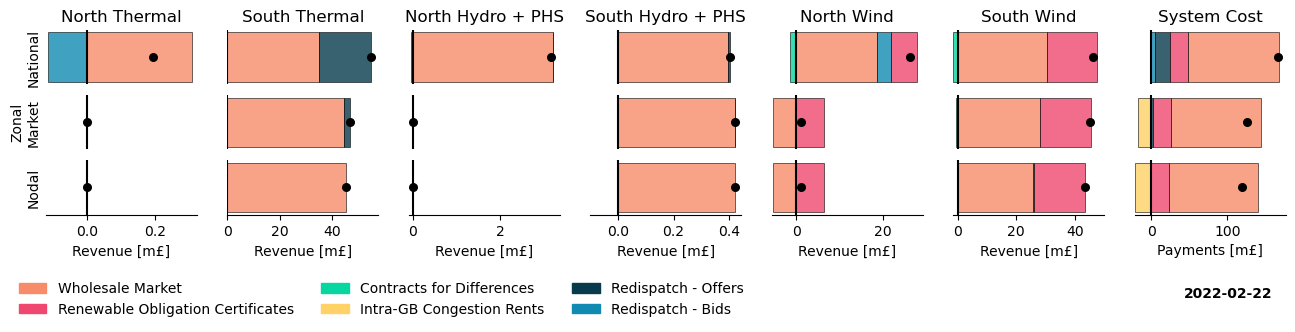

In [120]:
date = '2022-02-22'

cost_summary = pd.read_csv(Path.cwd().parent / 'results' / f'{date}' / 'system_cost_summary_flex.csv', index_col=[0,1], parse_dates=True)

idx = pd.IndexSlice

total = rev.sum()

fig, axs = plt.subplots(3, 7, figsize=(16, 2.4))

for ax in axs.flatten():
    ax.axvline(0, color='k')

totals = {}

xlim_lower = np.zeros(7) - 0.1
xlim_upper = np.zeros(7) + 0.1

bar_kwargs = dict(
    edgecolor='k',
    linewidth=0.5,
    alpha=0.8
)


for k, (axs_row, layout) in enumerate(zip(axs, ['national', 'zonal', 'nodal'])):

    totals[layout] = {}

    df = pd.read_csv(
        # path.format(layout),
        # str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv').format('2022-11-29', layout),
        str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv').format(date, layout),
        index_col=0,
        header=[0,1,2],
        parse_dates=True
        )
    
    rev = df.loc[:,~df.columns.get_level_values(1).str.contains('load')].mul(1e-6)

    load_payment = abs(df.loc[:,idx[:,'load',:]].sum().sum() * 1e-6)
    load_payment = cost_summary[layout].unstack().sum().drop('balancing_volume')

    total = load_payment.sum()

    neg = load_payment[load_payment < 0]
    pos = load_payment[load_payment > 0]

    xlim_lower[-1] = min(xlim_lower[-1], neg.sum()*1.05)
    xlim_upper[-1] = max(xlim_upper[-1], pos.sum()*1.05)

    for iloc, index in enumerate(neg.index):
        neg_val = neg.loc[index]  # negative value
        cum_neg = neg.iloc[:iloc+1].sum()

        # Plot the negative portion
        axs_row[-1].barh(
            y=0,
            left=cum_neg,
            width=-neg_val,   # negative number -> extends to the left
            color=color_dict[index],
            **bar_kwargs
        )

    for iloc, index in enumerate(pos.index):

        pos_val = pos.loc[index]  # positive value

        if iloc > 0:
            cum_pos = pos.iloc[:iloc].sum()
        else:
            cum_pos = 0

        # Plot the positive portion, starting where the negative bar ends
        axs_row[-1].barh(
            y=0,
            left=cum_pos,    # start of the positive bar
            width=pos_val,   # extends to the right
            color=color_dict[index],
            **bar_kwargs
        )

    axs_row[-1].scatter([total], [0], color='k', s=30)


    totals[layout] = {}

    for j, i in enumerate(rev.T.groupby(level=[0,1]).sum().T.sum().sort_index(level=1).index):

        ax = axs_row[j]

        place, carrier = i

        ss = rev.loc[:, idx[place, carrier, :]].sum()

        ss.index = ss.index.droplevel([0,1])

        totals[layout][f'{place} {carrier}'] = ss

        total = ss.sum()

        neg = ss[ss < 0]
        pos = ss[ss > 0]

        xlim_lower[j] = min(xlim_lower[j], neg.sum()*1.05)
        xlim_upper[j] = max(xlim_upper[j], pos.sum()*1.05)

        for iloc, index in enumerate(neg.index):
            neg_val = neg.loc[index]  # negative value
            cum_neg = neg.iloc[:iloc+1].sum()

            # Plot the negative portion
            ax.barh(
                y=0,
                left=cum_neg,
                width=-neg_val,   # negative number -> extends to the left
                color=color_dict[mapping_dict[index]],
                **bar_kwargs
            )

        for iloc, index in enumerate(pos.index):

            pos_val = pos.loc[index]  # positive value

            if iloc > 0:
                cum_pos = pos.iloc[:iloc].sum()
            else:
                cum_pos = 0

            # Plot the positive portion, starting where the negative bar ends
            ax.barh(
                y=0,
                left=cum_pos,    # start of the positive bar
                width=pos_val,   # extends to the right
                color=color_dict[mapping_dict[index]],
                **bar_kwargs
            )

        ax.scatter([total], [0], color='k', s=30)

        if k == 0:
            ax.set_title(nice_titles[f'{place} {carrier}'])
        
    for ax in axs_row:

        ax.set_yticks([])

        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if k < 2:
            ax.spines['bottom'].set_visible(False)

        if k < 2:
            ax.set_xticks([])


for i in range(7):
    for ax in axs[:, i]:
        ax.set_xlim(xlim_lower[i], xlim_upper[i])

axs[2,-1].text(
    # (xlim_upper[-1] + xlim_lower[-1]) / 2,
    xlim_upper[-1] * 0.9,
    - 1.78,
    f'{date}',
    weight='bold',
    fontsize=10,
    ha='right',
)

for ax in axs[2,:-1]:
    ax.set_xlabel('Revenue [m£]')

axs[-1,-1].set_xlabel('Payments [m£]')
axs[0,-1].set_title('System Cost')

handles, labels = [], []

for name, nice_name in nice_names.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[2,0].legend(
    handles,
    labels,
    # title='Cost Factors',
    bbox_to_anchor=(4.7, -1.),
    frameon=False,
    ncol=3
    )

for ax, label in zip(axs[:,0], ['National', 'Zonal\nMarket', 'Nodal']):
    ax.set_ylabel(label)

plt.show()

In [97]:
rev = pd.read_csv(
    path.format('zonal'),
    index_col=0,
    header=[0,1,2],
    parse_dates=True
    )

<Axes: xlabel='snapshot'>

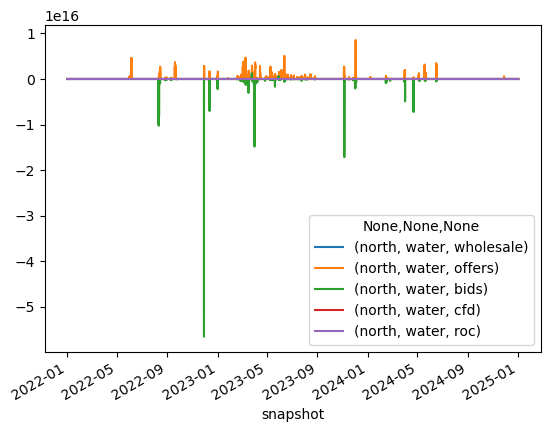

In [103]:
rev.loc[:,idx['north','water',:]].plot()

In [107]:
minidx = rev.loc[:,idx['north','water','bids']].argmin()
rev.index[minidx]

Timestamp('2022-11-29 02:00:00')

In [96]:
totals['zonal']

{'north disp': wholesale    2.440305e+08
 offers       8.665567e+08
 bids        -1.829300e+07
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'south disp': wholesale    5.502318e+10
 offers       2.955273e+08
 bids        -6.918722e+08
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'north water': wholesale    4.785727e+08
 offers       2.398674e+18
 bids        -8.270296e+17
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'south water': wholesale    4.473022e+08
 offers       3.460939e+18
 bids        -5.495305e+17
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'north wind': wholesale    5.333890e+07
 offers       5.227853e+09
 bids         1.008063e+05
 cfd          4.201156e+07
 roc          3.613934e+09
 dtype: float64,
 'south wind': wholesale    1.492992e+10
 offers       8.174059e+04
 bids         0.000000e+00
 cfd          6.291174e+08
 roc          1.013803e+10
 dtype: float64}

In [85]:
totals

{'north disp': wholesale    8.175828e+08
 offers       0.000000e+00
 bids         0.000000e+00
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'south disp': wholesale    5.424832e+10
 offers       0.000000e+00
 bids         0.000000e+00
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'north water': wholesale    6.440411e+08
 offers       0.000000e+00
 bids         0.000000e+00
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'south water': wholesale    3.707074e+08
 offers       0.000000e+00
 bids         0.000000e+00
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'north wind': wholesale    1.707581e+08
 offers       0.000000e+00
 bids         0.000000e+00
 cfd          5.858605e+07
 roc          3.617282e+09
 dtype: float64,
 'south wind': wholesale    1.499427e+10
 offers       0.000000e+00
 bids         0.000000e+00
 cfd          1.416757e+09
 roc          1.013807e+10
 dtype: float64}

In [20]:
rev.T.groupby(level=[0,1]).sum().T.sum().sort_index(level=1)

north  disp     1.458374e+09
south  disp     5.680355e+10
north  water    1.534691e+09
south  water    5.476507e+08
north  wind     1.317783e+10
south  wind     2.613871e+10
dtype: float64

In [138]:
day = '2022-11-29'

path = str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv')

zon = pd.read_csv(path.format(day, 'zonal'), index_col=0, header=[0,1,2], parse_dates=True)

In [139]:
zon.sum().sort_values()

south  disp   bids        -1.644673e+06
       wind   cfd         -5.799604e+05
north  wind   cfd         -3.449497e+05
       water  roc          0.000000e+00
south  water  bids         0.000000e+00
              offers       0.000000e+00
       disp   roc          0.000000e+00
              cfd          0.000000e+00
              offers       0.000000e+00
       wind   bids         0.000000e+00
              offers       0.000000e+00
       water  cfd          0.000000e+00
north  water  cfd          0.000000e+00
south  water  roc          0.000000e+00
north  water  offers       0.000000e+00
       disp   roc          0.000000e+00
              cfd          0.000000e+00
              bids         0.000000e+00
       wind   bids         0.000000e+00
              offers       0.000000e+00
       water  bids         0.000000e+00
       wind   roc          6.858950e+05
south  water  wholesale    8.417750e+05
       wind   roc          9.423970e+05
north  disp   wholesale    1.580580e+06


In [ ]:
path = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_{}.csv')
rev = pd.read_csv(path.format(''), index_col=0, header=[0,1,2], parse_dates=True)

rev.loc['2022-11-29'].sum().sort_values()

north  water  bids        -6.582777e+16
south  water  bids        -6.528644e+16
       disp   bids        -5.679807e+06
       wind   cfd         -5.799604e+05
north  wind   cfd         -3.449497e+05
       water  roc          0.000000e+00
south  disp   roc          0.000000e+00
              cfd          0.000000e+00
              offers       0.000000e+00
       wind   bids         0.000000e+00
              offers       0.000000e+00
       water  cfd          0.000000e+00
north  water  cfd          0.000000e+00
south  water  roc          0.000000e+00
north  disp   roc          0.000000e+00
              cfd          0.000000e+00
              bids         0.000000e+00
       wind   bids         0.000000e+00
              offers       0.000000e+00
              roc          6.858950e+05
south  water  wholesale    8.417750e+05
       wind   roc          9.423970e+05
north  disp   wholesale    1.580580e+06
south  wind   wholesale    3.321961e+06
north  wind   wholesale    3.815020e+06


In [128]:
import pypsa

n = pypsa.Network(Path.cwd().parent / 'results' / '2022-11-29' / 'network_flex_s_national_solved.nc')

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units


<Axes: xlabel='snapshot'>

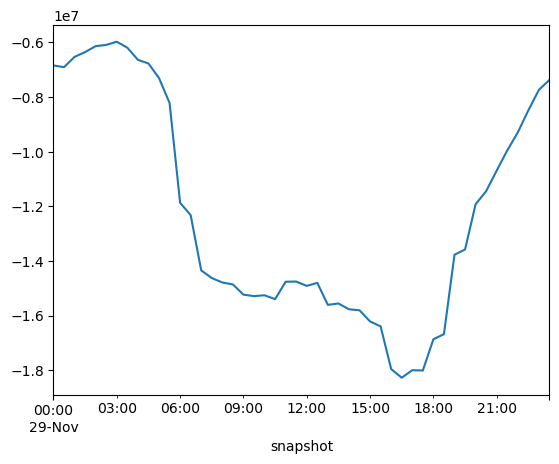

In [131]:
# help(n.statistics.revenue)
n.statistics.revenue(aggregate_time=False, comps='Load').loc['electricity'].plot()